# Intro

This code is used to understand the performance of regression and classification models on the dataset for a concept bottleneck model. Specifically, it is used to see how well the concept predictor (`x_to_c` component) of the CBM performs on the chosen features and concepts.

The dataset was constructed in the following manner:

### `cohorta`
*   Patients between ages 18 and 90
*   Patients only had one ICU admission
*   Patients were in the ICU for 48 hours or less

### `cohorta_trial1_data`

This script returns the features, concepts and labels associated with patients from cohorta. Using the work done in [Predicting In-Hospital Mortality of Lung Cancer Patients](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9879439/) in the ICU paper as inspiration, the SOFA score, Aniongap, Albumin, and Total Bilirubin values were chosen for the mortality prediction task.

**Features**

Since we are only looking at patients who were admitted to the ICU once for less than 48 hours, the **lab measurements were from the patient's first day in the ICU**. The measurements chosen were the ones that help evaluate the SOFA score, Aniongap, Albumin, and Total Bilirubin.

<u>*SOFA Related*</u>
1. rsp_pao2fio2_vent_min
2. rsp_pao2fio2_novent_min
3. cgn_platelet_min
4. lvr_bilirubin_max
5. cdv_mbp_min
6. cdv_rate_dopamine
7. cdv_rate_dobutamine
8. cdv_rate_epinephrine
9. cdv_rate_norepinephrine
10. gcs_min
11. rfl_urineoutput
12. rfl_creatinine_max

The first 3 letters reflect which individual component's calculation of the SOFA score the lab measurement contributes to: respiratory, coagulation, liver (hepatic), cardiovascular, neurological (Glasgow coma scale), renal.

<u>*Other lab values*</u>
1. albumin
2. anion_gap
3. total_bilirubin = lvr_bilirubin_max

**Concepts**

All the concepts are binary flags (1 represents that it has occurred, 0 means not occurred).

<u>*Individual Component SOFA Failure*</u>

* Organ failure moderate (name_moderate): Organ SOFA score 1-3
* Organ failure severe (name_severe): Organ SOFA score 4

12 concepts: rsp_fail_moderate, rsp_fail_severe, cgn_fail_moderate, cgn_fail_severe, lvr_fail_moderate, lvr_fail_severe, cdv_fail_moderate, cdv_fail_severe, gcs_fail_moderate, gcs_fail_severe, rfl_fail_moderate, rfl_fail_severe

<u>*Combining the Individual SOFA Components*</u>

| Potential Condition                  | Code | Criteria                                                  |
|--------------------------------------|------|-----------------------------------------------------------|
| Septic Shock                         | SSH  | Cardiovascular Score ≥ 3 and any other organ score ≥ 2    |
| ARDS                                 | ARD  | Respiratory score ≥ 3 and Cardiovascular score ≥ 1 and CNS score ≥ 2 |
| Hepatorenal Syndrome                 | HES  | Liver score ≥ 2 and renal score ≥ 2                       |
| Coagulopathy-Related Organ Dysfunction | COD  | Coagulation score ≥ 3 and liver score ≥ 2                 |
| Multiple Organ Dysfunction Syndrome  | MOD  | Failure scores ≥ 2 in three or more organ systems         |
| CNS and Renal Failure                | CRF  | CNS score ≥ 3 and renal score ≥ 2                         |
| Liver and Coagulation Failure        | LCF  | Liver score ≥ 3 and coagulation score ≥ 3                 |

<u>*Other Concepts*</u>
1. High Aniongap: aniongap > 12
2. Low Albumin: < 3.4 g/dL
3. High Albumin: > 5.4 g/dL
4. High bilirubin: > 1.2 md/dL

**Label**

For now, the label is mortality within the year. Since MIMIC contains the date of death for patients that died within a year, if the dod column for the patient is populated, `mortality_year` is 1 otherwise, it is 0.



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Load Data

In [ ]:
# Using the following CSV file from GitHub: https://github.com/anish-narain/final-year-project
file_path = '/content/cohorta_trial1_data.csv'
df = pd.read_csv(file_path)

print(df.head())  # Display the first few rows of the dataframe

   subject_id   hadm_id   stay_id         dod  mortality_year  aniongap_max  \
0    13730554  28211964  35400714         NaN               0          12.0   
1    19643038  29928288  32947476         NaN               0          20.0   
2    18126966  28314801  37538158  2111-04-25               1          15.0   
3    18507022  25623992  39771363  2118-05-15               1          10.0   
4    15511499  25185580  36407234  2181-12-18               1          24.0   

   albumin_min  albumin_max  rsp_pao2fio2_vent_min  rsp_pao2fio2_novent_min  \
0          NaN          NaN                    NaN                      NaN   
1          NaN          NaN                    NaN                      NaN   
2          NaN          NaN                    NaN                      NaN   
3          NaN          NaN                    NaN                      NaN   
4          NaN          NaN                    NaN                      NaN   

   ...  ARD  HES  COD  MOD  CRF  LCF  flag_high_an

# Investigating the Data

1. Significant Imbalance: Labels like `rsp_fail_severe`, `cgn_fail_severe`, `lvr_fail_severe`, `gcs_fail_severe`, and particularly `flag_high_albumin` have extreme imbalances where the positive class (indicating the presence of a condition) is very rare (around 0.5% to 6.7%).

2. Moderate Imbalance: Other labels like `rsp_fail_moderate`, `cgn_fail_moderate`, and `gcs_fail_moderate` have a more balanced distribution but still show some degree of skew.

3. Reverse Imbalance: `cdv_fail_moderate` and `flag_high_aniongap` show a reverse imbalance where the majority of cases fall into the positive class.



In [ ]:
# Labels for which to check the distribution
label_columns = ['rsp_fail_moderate', 'rsp_fail_severe', 'cgn_fail_moderate', 'cgn_fail_severe', 'lvr_fail_moderate',
                 'lvr_fail_severe', 'cdv_fail_moderate', 'cdv_fail_severe', 'gcs_fail_moderate', 'gcs_fail_severe',
                 'rfl_fail_moderate', 'rfl_fail_severe', 'SSH', 'ARD', 'HES', 'COD', 'MOD', 'CRF', 'LCF',
                 'flag_high_aniongap', 'flag_low_albumin', 'flag_high_albumin', 'flag_high_bilirubin']

# List to store each row of the new DataFrame
rows = []

# Loop through each label and count the occurrences of each class
for label in label_columns:
    # Count the occurrences of each class (0 and 1)
    class_count = df[label].value_counts(normalize=True)  # Use normalize=True to get the proportion
    # Create a dictionary for the current row and add to the list
    row = {'Label': label,
           'Class 0 (Negative)': class_count.get(0, 0),
           'Class 1 (Positive)': class_count.get(1, 0)}
    rows.append(row)

# Create a DataFrame from the list of rows
class_distribution = pd.DataFrame(rows)

# Set the 'Label' column as the index for better readability
class_distribution.set_index('Label', inplace=True)

# Print the class distribution DataFrame
print(class_distribution)


                     Class 0 (Negative)  Class 1 (Positive)
Label                                                      
rsp_fail_moderate              0.821274            0.178726
rsp_fail_severe                0.965392            0.034608
cgn_fail_moderate              0.675011            0.324989
cgn_fail_severe                0.993268            0.006732
lvr_fail_moderate              0.898419            0.101581
lvr_fail_severe                0.991872            0.008128
cdv_fail_moderate              0.306986            0.693014
cdv_fail_severe                0.939859            0.060141
gcs_fail_moderate              0.661746            0.338254
gcs_fail_severe                0.968334            0.031666
rfl_fail_moderate              0.718396            0.281604
rfl_fail_severe                0.948885            0.051115
SSH                            0.921159            0.078841
ARD                            0.984890            0.015110
HES                            0.978607 

# Pre-processing the Data

Choices made:
* replaced all missing values with 0
* normalised features (inputs) to have zero mean and unit variance

In [ ]:
# Check for missing values
print(df.isnull().sum())

# Replace missing values with 0
df.fillna(0, inplace=True)

subject_id                     0
hadm_id                        0
stay_id                        0
dod                        15785
mortality_year                 0
aniongap_max                 425
albumin_min                13701
albumin_max                13701
rsp_pao2fio2_vent_min      15306
rsp_pao2fio2_novent_min    16777
cgn_platelet_min             277
lvr_bilirubin_max          11671
cdv_mbp_min                   24
cdv_rate_dopamine          19697
cdv_rate_dobutamine        19978
cdv_rate_epinephrine       19391
cdv_rate_norepinephrine    18409
gcs_min                      101
rfl_urineoutput              647
rfl_creatinine_max           244
sofa                           0
respiration                    0
coagulation                    0
liver                          0
cardiovascular                 0
cns                            0
renal                          0
rsp_fail_moderate              0
rsp_fail_severe                0
cgn_fail_moderate              0
cgn_fail_s

In [ ]:
# Features
X = df[['aniongap_max', 'albumin_max', 'albumin_min', 'rsp_pao2fio2_vent_min', 'rsp_pao2fio2_novent_min',
        'cgn_platelet_min', 'lvr_bilirubin_max', 'cdv_mbp_min', 'cdv_rate_dopamine', 'cdv_rate_dobutamine',
        'cdv_rate_epinephrine', 'cdv_rate_norepinephrine', 'gcs_min', 'rfl_urineoutput', 'rfl_creatinine_max']]

# Labels
Y = df[['rsp_fail_moderate', 'rsp_fail_severe', 'cgn_fail_moderate', 'cgn_fail_severe', 'lvr_fail_moderate',
        'lvr_fail_severe', 'cdv_fail_moderate', 'cdv_fail_severe', 'gcs_fail_moderate', 'gcs_fail_severe',
        'rfl_fail_moderate', 'rfl_fail_severe', 'SSH', 'ARD', 'HES', 'COD', 'MOD', 'CRF', 'LCF',
        'flag_high_aniongap', 'flag_low_albumin', 'flag_high_albumin', 'flag_high_bilirubin']]


# Convert features and labels to tensors
X_tensor = torch.tensor(X.values, dtype=torch.float32)
Y_tensor = torch.tensor(Y.values, dtype=torch.float32)

# Create TensorDataset
dataset = TensorDataset(X_tensor, Y_tensor)

# Split data into training and validation sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader for batch processing
train_loader_nonscaled = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader_nonscaled = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Normalising features for the neural network (scaling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to tensor after scaling
X_tensor_scaled = torch.tensor(X_scaled, dtype=torch.float32)

# Create new TensorDataset with scaled features
dataset_scaled = TensorDataset(X_tensor_scaled, Y_tensor)
train_dataset_scaled, test_dataset_scaled = torch.utils.data.random_split(dataset_scaled, [train_size, test_size])
train_loader = DataLoader(train_dataset_scaled, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset_scaled, batch_size=64, shuffle=False)

# Set Up Classification Model




In [ ]:
# This model will output a probability for each label using a sigmoid activation function on each output node
class MultiLabelNN(nn.Module):
    def __init__(self, num_features, num_labels):
        super(MultiLabelNN, self).__init__()
        self.layer1 = nn.Linear(num_features, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, num_labels)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.output_layer(x))  # Sigmoid activation to output probabilities for each label
        return x


# Train Classification Model

In [ ]:
# Initialize the model, loss, and optimizer
model = MultiLabelNN(num_features=15, num_labels=23)  # 15 features and 23 binary labels
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification tasks
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
training_losses = []
validation_losses = []

best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate average training loss for the epoch
    train_loss /= len(train_loader)
    training_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    val_loss /= len(test_loader)
    validation_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1, Training Loss: 0.2503, Validation Loss: 0.1591
Epoch 2, Training Loss: 0.1346, Validation Loss: 0.1117
Epoch 3, Training Loss: 0.0980, Validation Loss: 0.0874
Epoch 4, Training Loss: 0.0803, Validation Loss: 0.0785
Epoch 5, Training Loss: 0.0710, Validation Loss: 0.0691
Epoch 6, Training Loss: 0.0644, Validation Loss: 0.0641
Epoch 7, Training Loss: 0.0597, Validation Loss: 0.0610
Epoch 8, Training Loss: 0.0556, Validation Loss: 0.0570
Epoch 9, Training Loss: 0.0526, Validation Loss: 0.0547
Epoch 10, Training Loss: 0.0499, Validation Loss: 0.0523
Epoch 11, Training Loss: 0.0477, Validation Loss: 0.0499
Epoch 12, Training Loss: 0.0457, Validation Loss: 0.0486
Epoch 13, Training Loss: 0.0439, Validation Loss: 0.0471
Epoch 14, Training Loss: 0.0422, Validation Loss: 0.0456
Epoch 15, Training Loss: 0.0408, Validation Loss: 0.0451
Epoch 16, Training Loss: 0.0398, Validation Loss: 0.0446
Epoch 17, Training Loss: 0.0385, Validation Loss: 0.0434
Epoch 18, Training Loss: 0.0375, Validat

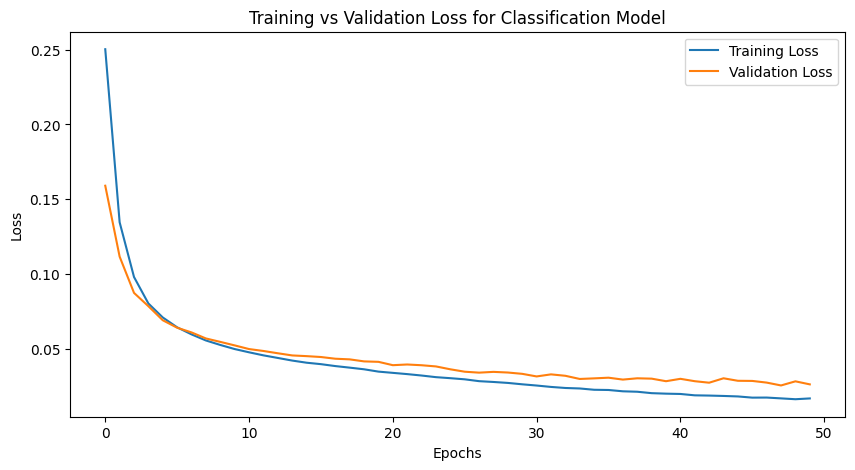

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training vs Validation Loss for Classification Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Classification Model Evaluation

In [ ]:
# Create arrays to store metrics for each label
precisions = []
recalls = []
f1_scores = []
accuracies = []

model.eval()
with torch.no_grad():
    all_labels = []
    all_predictions = []

    # Collect all labels and predictions
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = outputs.round()
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())

    # Concatenate all batches
    all_labels = np.vstack(all_labels)
    all_predictions = np.vstack(all_predictions)

    # Calculate metrics for each label
    for label_index in range(all_labels.shape[1]):
        label_true = all_labels[:, label_index]
        label_pred = all_predictions[:, label_index]

        precision = precision_score(label_true, label_pred, zero_division=0)
        recall = recall_score(label_true, label_pred, zero_division=0)
        f1 = f1_score(label_true, label_pred, zero_division=0)
        accuracy = accuracy_score(label_true, label_pred)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        accuracies.append(accuracy)

# Display the results for each label
label_names = Y.columns
data = {
    'Label': label_names,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1_scores,
    'Accuracy': accuracies
}

results_df = pd.DataFrame(data)
print(results_df)

                  Label  Precision    Recall  F1-Score  Accuracy
0     rsp_fail_moderate   0.893004  0.936691  0.914326  0.969584
1       rsp_fail_severe   0.816901  0.846715  0.831541  0.988282
2     cgn_fail_moderate   0.982733  0.978326  0.980524  0.987036
3       cgn_fail_severe   0.458333  0.523810  0.488889  0.994266
4     lvr_fail_moderate   0.980676  0.962085  0.971292  0.994016
5       lvr_fail_severe   0.935484  0.906250  0.920635  0.998753
6     cdv_fail_moderate   0.983075  0.991465  0.987252  0.982049
7       cdv_fail_severe   0.948498  0.952586  0.950538  0.994266
8     gcs_fail_moderate   0.992738  0.994182  0.993459  0.995512
9       gcs_fail_severe   0.937008  0.881481  0.908397  0.994016
10    rfl_fail_moderate   0.898671  0.955830  0.926370  0.957118
11      rfl_fail_severe   0.900000  0.663594  0.763926  0.977811
12                  SSH   0.916933  0.940984  0.928803  0.989030
13                  ARD   0.790323  0.907407  0.844828  0.995512
14                  HES  

# Set Up Regression Model

In [ ]:
class MultiOutputNN(nn.Module):
    def __init__(self, num_features, num_outputs):
        super(MultiOutputNN, self).__init__()
        self.layer1 = nn.Linear(num_features, 64)
        self.layer2 = nn.Linear(64, 128)
        self.layer3 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, num_outputs)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = self.output_layer(x)  # No activation function
        return x

# Train Regression Model

In [ ]:
# Initialize the model, loss, and optimizer
model = MultiOutputNN(num_features=15, num_outputs=23)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
training_losses = []
validation_losses = []

best_val_loss = float('inf')
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate average training loss for the epoch
    train_loss /= len(train_loader)
    training_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate average validation loss for the epoch
    val_loss /= len(test_loader)
    validation_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1, Training Loss: 0.0610, Validation Loss: 0.0426
Epoch 2, Training Loss: 0.0334, Validation Loss: 0.0287
Epoch 3, Training Loss: 0.0259, Validation Loss: 0.0244
Epoch 4, Training Loss: 0.0224, Validation Loss: 0.0217
Epoch 5, Training Loss: 0.0201, Validation Loss: 0.0196
Epoch 6, Training Loss: 0.0183, Validation Loss: 0.0181
Epoch 7, Training Loss: 0.0170, Validation Loss: 0.0169
Epoch 8, Training Loss: 0.0159, Validation Loss: 0.0162
Epoch 9, Training Loss: 0.0148, Validation Loss: 0.0155
Epoch 10, Training Loss: 0.0142, Validation Loss: 0.0153
Epoch 11, Training Loss: 0.0136, Validation Loss: 0.0145
Epoch 12, Training Loss: 0.0131, Validation Loss: 0.0137
Epoch 13, Training Loss: 0.0126, Validation Loss: 0.0133
Epoch 14, Training Loss: 0.0123, Validation Loss: 0.0132
Epoch 15, Training Loss: 0.0119, Validation Loss: 0.0131
Epoch 16, Training Loss: 0.0116, Validation Loss: 0.0123
Epoch 17, Training Loss: 0.0113, Validation Loss: 0.0124
Epoch 18, Training Loss: 0.0110, Validat

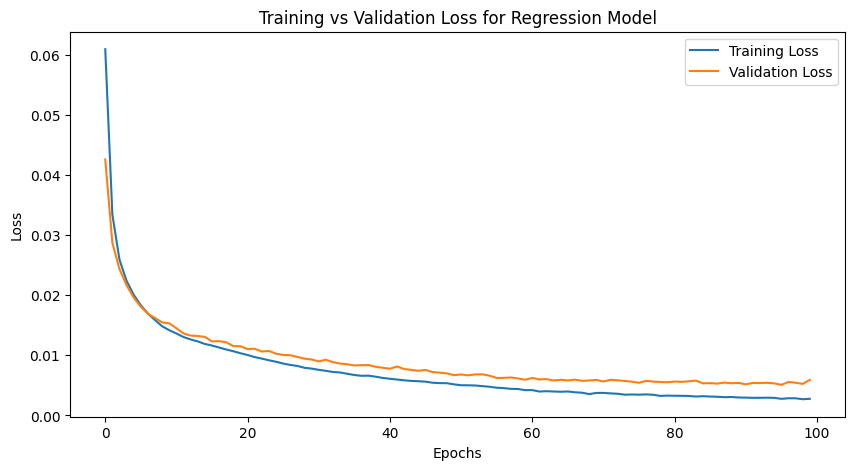

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training vs Validation Loss for Regression Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Regression Model Evaluation

In [ ]:
# Create arrays to store metrics for each outputs
mse_scores = []
mae_scores = []
r2_scores = []

model.eval()
with torch.no_grad():
    all_labels = []
    all_predictions = []

    # Collect all labels and predictions
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = outputs.round()
        all_labels.append(labels.cpu().numpy())
        all_predictions.append(predicted.cpu().numpy())

    # Concatenate all batches
    all_labels = np.vstack(all_labels)
    all_predictions = np.vstack(all_predictions)

    # Calculate metrics for each label
    for label_index in range(all_labels.shape[1]):
        label_true = all_labels[:, label_index]
        label_pred = all_predictions[:, label_index]

        mse = mean_squared_error(label_true, label_pred)
        mae = mean_absolute_error(label_true, label_pred)
        r2 = r2_score(label_true, label_pred)

        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)

# Display the results for each label
label_names = Y.columns
data = {
    'Label': label_names,
    'MSE': mse_scores,
    'MAE': mae_scores,
    'R2': r2_scores
}

results_df = pd.DataFrame(data)
print(results_df)

                  Label       MSE       MAE        R2
0     rsp_fail_moderate  0.012964  0.012964  0.912639
1       rsp_fail_severe  0.008477  0.008477  0.727676
2     cgn_fail_moderate  0.019447  0.019447  0.912458
3       cgn_fail_severe  0.003740  0.003740  0.440679
4     lvr_fail_moderate  0.005734  0.005734  0.939469
5       lvr_fail_severe  0.000997  0.000997  0.877782
6     cdv_fail_moderate  0.005236  0.005236  0.975834
7       cdv_fail_severe  0.004737  0.004737  0.922136
8     gcs_fail_moderate  0.001496  0.001496  0.993344
9       gcs_fail_severe  0.003490  0.003490  0.891911
10    rfl_fail_moderate  0.021192  0.021192  0.895942
11      rfl_fail_severe  0.023685  0.023685  0.458872
12                  SSH  0.006981  0.006981  0.904914
13                  ARD  0.002493  0.002493  0.825056
14                  HES  0.009225  0.009225  0.550102
15                  COD  0.004488  0.004488  0.545467
16                  MOD  0.008726  0.008726  0.569403
17                  CRF  0.0